In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

from vixstructure.utils import parse_whole_directory_old, parse_whole_directory

from vixstructure.data import LongPricesDataset
from vixstructure.models import term_structure_to_spread_price_v2

In [2]:
def plot3d_loss(dataframe, zlim=None, rotation=225):
    X = dataframe.index.levels[0]
    Y = dataframe.index.levels[1]
    X, Y = np.meshgrid(X, Y)
    Z = np.reshape(
            np.array(list(map(lambda x: dataframe.get((x[0], x[1]), default=0.45),
                              np.reshape(np.dstack((X,Y)), (X.shape[0]*X.shape[1],2))))),
            X.shape)
    fig = plt.figure(figsize=(5, 5))
    ax = fig.gca(projection='3d')
    ax.plot_surface(X, Y, Z, linewidth=None, antialiased=True, cmap=cm.coolwarm_r)
    ax.view_init(azim=rotation)
    ax.set_xlabel("Depth")
    ax.set_ylabel("Width")
    ax.set_xlim(X[0,0], X[-1,-1])
    ax.set_ylim(Y[0,0], Y[-1,-1])
    ax.set_zlim(zlim)
    #ax.set_zlabel("Loss", rotation=90)

In [3]:
experiment1 = parse_whole_directory_old("models/experiment01/")
experiment2 = parse_whole_directory_old("models/experiment02/")
experiment3 = parse_whole_directory_old("models/experiment03/")
experiment4 = parse_whole_directory_old("models/experiment04/")

# Experiment 1

Basic estimation of width and depth.

In [4]:
argmin_epchs_basic = np.array([v[3] for v in experiment1["val_loss"].loc[:,:,False].groupby(("depth", "width", "datetime")).idxmin()])
argmin_epchs_normal = np.array([v[3] for v in experiment1["val_loss"].loc[:,:,True].groupby(("depth", "width", "datetime")).idxmin()])
print(argmin_epchs_basic.mean(), argmin_epchs_basic.std(), np.median(argmin_epchs_basic))
print(argmin_epchs_normal.mean(), argmin_epchs_normal.std(), np.median(argmin_epchs_normal))

700.556666667 255.444775745 750.5
407.913043478 307.661150851 293.0


In [5]:
ex1_min = experiment1.groupby(("depth", "width", "normalized", "datetime")).min()
ex1_min_basic = ex1_min.loc(axis=0)[:,:,False]
ex1_min_normal = ex1_min.loc(axis=0)[:,:,True]

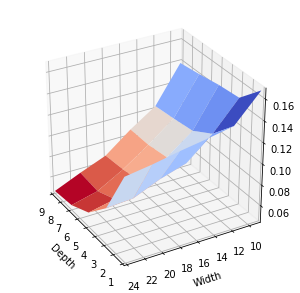

In [6]:
plot3d_loss(ex1_min_basic["loss"].groupby(("depth", "width")).mean(), rotation=150)
plt.savefig("approach1-ex1-loss-basic.pdf", format="pdf", bbox_inches="tight", dpi=300)
plt.show()

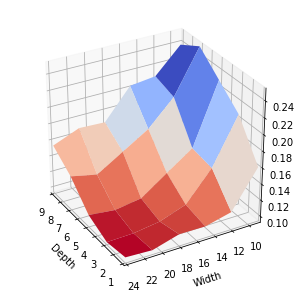

In [7]:
plot3d_loss(ex1_min_basic["val_loss"].groupby(("depth", "width")).mean(), rotation=150)
plt.savefig("approach1-ex1-val-basic.pdf", format="pdf", bbox_inches="tight", dpi=300)
plt.show()

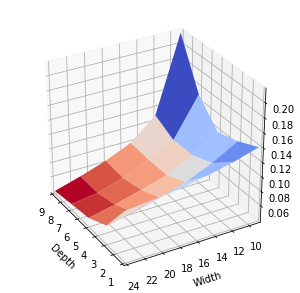

In [8]:
plot3d_loss(ex1_min_normal["loss"].groupby(("depth", "width")).mean(), rotation=150)
plt.savefig("approach1-ex1-loss-normal.pdf", format="pdf", bbox_inches="tight", dpi=300)
plt.show()

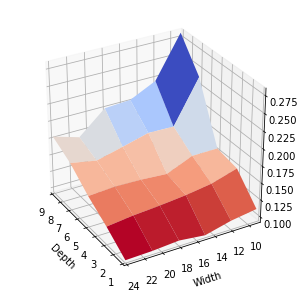

In [9]:
plot3d_loss(ex1_min_normal["val_loss"].groupby(("depth", "width")).mean(), rotation=150)
plt.savefig("approach1-ex1-val-normal.pdf", format="pdf", bbox_inches="tight", dpi=300)
plt.show()

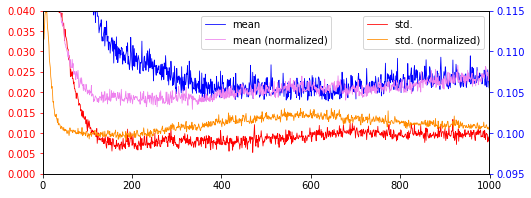

In [10]:
d1w21_basic = experiment1["val_loss"].loc[1, 24, False]
d1w21_normal = experiment1["val_loss"].loc[1, 24, True]
plt.figure(figsize=(8,3))
ax2 = d1w21_basic.groupby("epoch").std().plot(color="red", linewidth=0.8)
d1w21_normal.groupby("epoch").std().plot(color="darkorange", linewidth=0.8)
ax2.tick_params(axis="y", colors="red")
plt.legend(("std.", "std. (normalized)"), title="")
plt.ylim(0, 0.04)
ax1 = d1w21_basic.groupby("epoch").mean().plot(secondary_y=True, color="blue", linewidth=0.8)
d1w21_normal.groupby("epoch").mean().plot(secondary_y=True, color="violet", linewidth=0.8)
ax1.tick_params(axis="y", colors="blue")
ax1.set_xlabel("")
ax2.set_xlabel("")
plt.legend(("mean", "mean (normalized)"), loc="upper center", title="")
plt.ylim(0.095,0.115)
plt.savefig("approach1-ex1-progression.pdf", format="pdf", bbox_inches="tight", dpi=300)
plt.show()

In [11]:
print(experiment1.min(), experiment1.idxmin(), sep="\n")

loss        0.034753
val_loss    0.074803
dtype: float32
loss         (9, 24, True, 2017-07-03 15:29:55, 957)
val_loss    (3, 21, False, 2017-07-03 15:13:45, 700)
dtype: object


# Experiment 2

Using days to expiration as an explicit prior.

In [12]:
ex2_min = experiment2["val_loss"][1,:,False].groupby(("width", "datetime")).min()

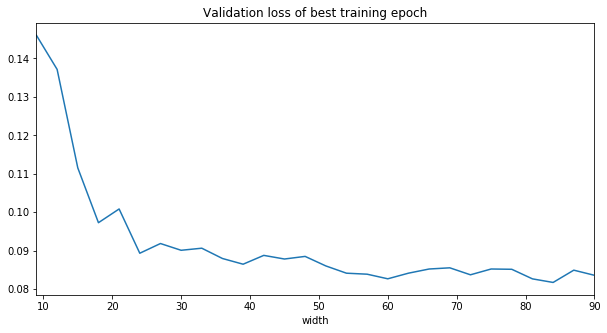

In [19]:
ex2_min.groupby("width").mean().plot(figsize=(10,5))
plt.title("Validation loss of best training epoch")
plt.show()

In [32]:
experiment2.loc[1,9,False,:,999]

,loss,val_loss
datetime,,
2017-07-07 10:50:50,0.156772,0.158806
2017-07-07 10:50:52,0.166922,0.163294
2017-07-07 10:50:52,0.159244,0.118366
2017-07-07 10:50:53,0.169292,0.221470
2017-07-07 10:50:54,0.137462,0.146191
2017-07-07 10:50:54,0.166689,0.152251
2017-07-07 10:50:54,0.161632,0.158894
2017-07-07 10:50:55,0.139395,0.115619
2017-07-07 10:51:34,0.150330,0.150294


# Experiment 3

Trying out regularization with SeLU activation function.

In [14]:
ex3_min = experiment3["val_loss"][:,:,False].groupby(("depth", "width", "datetime")).min()
experiment3.groupby(("depth", "width", "normalized", "datetime")).min()

loss  val_loss
depth width normalized datetime                               
1     3     False      2017-07-07 15:09:58  0.227226  0.303259
      6     False      2017-07-07 15:10:03  0.157348  0.127234
      9     False      2017-07-07 15:09:58  0.136526  0.101006
      12    False      2017-07-07 15:09:58  0.114042  0.093892
      15    False      2017-07-07 15:09:58  0.120282  0.101878
      18    False      2017-07-07 15:09:57  0.112638  0.093489
      21    False      2017-07-07 15:09:55  0.110029  0.092254
      24    False      2017-07-07 15:09:57  0.102090  0.090895
      27    False      2017-07-07 15:09:57  0.094301  0.086356
      30    False      2017-07-07 15:09:56  0.101178  0.088923
      33    False      2017-07-07 15:09:57  0.098583  0.079747
4     3     False      2017-07-07 15:10:03  0.226650  0.298832
      6     False      2017-07-07 15:09:58  0.131592  0.176661
      9     False      2017-07-07 15:10:03  0.109431  0.135244
      12    False      2017-07-07 15:10:04  0.090935  0.104784
      15    False      2017-07-07 15:09:58  0.075992  0.117263
      18    False      2017-07-07 15:09:56  0.073638  0.101192
      21    False      2017-07-07 15:09:57  0.062421  0.090045
      24    False      2017-07-07 15:09:58  0.058803  0.093860
      27    False      2017-07-07 15:09:59  0.053730  0.093130
      30    False      2017-07-07 15:09:56  0.043519  0.103321
      33    False      2017-07-07 15:09:57  0.040668  0.089313
7     3     False      2017-07-07 15:10:03  0.238643  0.305181
      6     False      2017-07-07 15:09:58  0.147180  0.250486
      9     False      2017-07-07 15:09:58  0.100005  0.131707
      12    False      2017-07-07 15:09:55  0.070405  0.113367
      15    False      2017-07-07 15:09:58  0.061198  0.124002
      18    False      2017-07-07 15:09:56  0.049842  0.118765
      21    False      2017-07-07 15:10:03  0.042158  0.100945
      24    False      2017-07-07 15:09:56  0.040189  0.100826
...                                              ...       ...
94    12    False      2017-07-07 16:02:10  0.488258  0.445389
      15    False      2017-07-07 16:02:11  0.488218  0.446972
      18    False      2017-07-07 16:02:11  0.488274  0.445137
      21    False      2017-07-07 16:01:40  0.488278  0.436021
      24    False      2017-07-07 16:02:09  0.488013  0.438534
      27    False      2017-07-07 16:01:41  0.488128  0.434794
      30    False      2017-07-07 16:01:39  0.488263  0.440611
      33    False      2017-07-07 16:02:12  0.488056  0.435085
97    3     False      2017-07-07 16:01:42  0.488267  0.443431
      6     False      2017-07-07 16:01:41  0.488102  0.446900
      9     False      2017-07-07 16:02:10  0.462172  0.423553
      12    False      2017-07-07 16:02:03  0.488051  0.449025
      15    False      2017-07-07 16:02:15  0.488262  0.439621
      18    False      2017-07-07 16:01:41  0.488250  0.439389
      21    False      2017-07-07 16:02:09  0.487842  0.432468
      24    False      2017-07-07 16:02:11  0.488205  0.439876
      27    False      2017-07-07 16:02:08  0.488338  0.435534
      30    False      2017-07-07 16:02:15  0.488284  0.438601
      33    False      2017-07-07 16:02:10  0.488982  0.436250
100   3     False      2017-07-07 16:02:10  0.462695  0.448113
      6     False      2017-07-07 16:02:11  0.479789  0.445911
      9     False      2017-07-07 16:07:11  0.488120  0.443657
      12    False      2017-07-07 16:07:28  0.488290  0.443446
      15    False      2017-07-07 16:07:46  0.488627  0.442167
      18    False      2017-07-07 16:07:46  0.450130  0.442123
      21    False      2017-07-07 16:08:00  0.488876  0.433511
      24    False      2017-07-07 16:08:02  0.478684  0.437903
      27    False      2017-07-07 16:08:13  0.489205  0.436655
      30    False      2017-07-07 16:08:32  0.489233  0.434586
      33    False      2017-07-07 16:08:32  0.488441  0.430754

[374 rows x 2 columns]

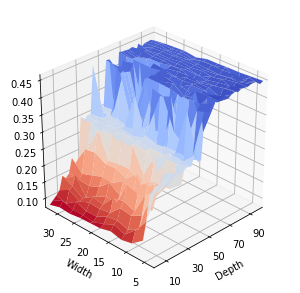

In [15]:
plot3d_loss(ex3_min.groupby(("depth", "width")).mean())
plt.xticks(np.arange(10, 100, 20))
plt.savefig("approach1-ex3-val-selu.pdf", format="pdf", bbox_inches="tight", dpi=300)
plt.show()

In [16]:
experiment35 = parse_whole_directory_old("models/experiment03.5/")

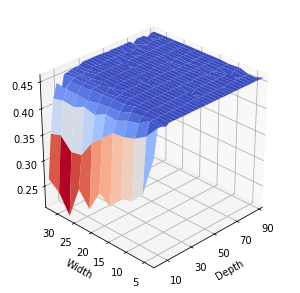

In [17]:
ex35_min = experiment35["val_loss"][:,:,False].groupby(("depth", "width", "datetime")).min()
experiment35.groupby(("depth", "width", "normalized", "datetime")).min()
plot3d_loss(ex35_min.groupby(("depth", "width")).mean())
plt.xticks(np.arange(10, 100, 20))
plt.savefig("approach1-ex3-val-dropout.pdf", format="pdf", bbox_inches="tight", dpi=300)
plt.show()

# Experiment 4

Using more input in hope of better performance.

In [18]:
ex4_min

NameError: name 'ex4_min' is not defined

In [ ]:
ex4_min = experiment4["val_loss"][1].groupby(("width", "normalized", "datetime")).min()
ex4_min_basic = ex4_min[:,False]
ex4_min_normal = ex4_min[:,True]

In [ ]:
ex4_min_basic.groupby("width").mean().plot(figsize=(10,5), label="not normalized")
ex4_min_normal.groupby("width").mean().plot(label="normalized")
plt.legend()
plt.title("Validation loss of best training epoch")
plt.show()

In [ ]:
ex4_per_width = pd.DataFrame(ex4_min_basic.values.reshape((11, 10)), index=ex4_min_basic.index.levels[0])
width = ex4_per_width.T.mean()
std = ex4_per_width.T.std()
ax = ex4_per_width.plot(colormap=cm.winter, legend=False, figsize=(8,4), alpha=0.8)
width.plot(linewidth=5)
plt.xticks(np.arange(20, 51, 3))
plt.grid()
plt.ylim(0.080, 0.110)
plt.xlabel("")
x = np.arange(20, 51, 3)
xx = np.concatenate((x, x[::-1]))
yy = np.concatenate((width.values + std.values, (width.values - std.values)[::-1]))
plt.fill(xx, yy, color="cyan", alpha=0.5)
#ax.xaxis.set_ticklabels(())
plt.savefig("approach1-ex4-val-basic.pdf", format="pdf", bbox_inches="tight", dpi=300)
plt.show()

In [ ]:
ex4_per_width = pd.DataFrame(ex4_min_normal.values.reshape((11, 10)), index=ex4_min_basic.index.levels[0])
width = ex4_per_width.T.mean()
std = ex4_per_width.T.std()
ex4_per_width.plot(colormap=cm.winter, legend=False, figsize=(8,3), alpha=0.8)
width.plot(linewidth=5)
plt.xticks(np.arange(20, 51, 3))
plt.ylim(0.155, 0.185)
plt.grid()
plt.xlabel("")
x = np.arange(20, 51, 3)
xx = np.concatenate((x, x[::-1]))
yy = np.concatenate((width.values + std.values, (width.values - std.values)[::-1]))
plt.fill(xx, yy, color="cyan", alpha=0.5)
plt.savefig("approach1-ex4-val-normal.pdf", format="pdf", bbox_inches="tight", dpi=300)
plt.show()

In [ ]:
ex4_min_basic

# General comparison

Looking at the validation loss of the best epoch.

In [101]:
def mse(y1, y2):
    return np.mean(np.square(y1 - y2))

def mse_prediction(model, splitted_datasets):
    return [mse(model.predict(x), y) for x, y in splitted_datasets]

In [162]:
longprices = LongPricesDataset("data/8_m_settle.csv", "data/expirations.csv")
(x_train, y_train), (_, y_val), (_, y_test) = longprices.splitted_dataset()

In [165]:
x_train[0]

array([ 11.89999962,   1.25      ,   0.93000031,   0.56999969,
         0.38000011,   0.5       ,   0.17000008,   0.        ,  23.        ], dtype=float32)

In [110]:
naive_mse = [mse(y_train[:-1], y_train[1:]), mse(y_val[:-1], y_val[1:]), mse(y_test[:-1], y_test[1:])]

In [135]:
comp_data = parse_whole_directory("models/comparison1-4/")

In [143]:
#pd.Series(comp_data.index.droplevel([0,1,2,3]), index=comp_data.index).groupby("datetime").max()
epochs= pd.Series([""]).append(
            pd.Series(comp_data.index.droplevel([0,1,2,3]), index=comp_data.index).groupby("datetime").max())
epochs.index = ["Naive", "Basic", "Dropout", "SNN", "AddIn"]
epochs

Naive         
Basic      307
Dropout    174
SNN        242
AddIn      268
dtype: object

In [107]:
model1 = term_structure_to_spread_price_v2(1, 30, input_data_length=9)
model1.load_weights("models/comparison1-4/20170826150648_schumpeter_depth1_width30_days1_dropout0e+00_optimAdam_lr1e-03.h5")
model2 = term_structure_to_spread_price_v2(1, 30, input_data_length=9, dropout=0.5)
model2.load_weights("models/comparison1-4/20170826150734_schumpeter_depth1_width30_days1_dropout5e-01_optimAdam_lr1e-03.h5")
model3 = term_structure_to_spread_price_v2(1, 30, input_data_length=9, activation_function="selu")
model3.load_weights("models/comparison1-4/20170826151132_schumpeter_depth1_width30_days1_dropout0e+00_optimAdam_lr1e-03.h5")
model4 = term_structure_to_spread_price_v2(1, 30, input_data_length=11)
model4.load_weights("models/comparison1-4/20170826151354_schumpeter_depth1_width30_days1_dropout0e+00_optimAdam_lr1e-03.h5")

In [155]:
longprices = LongPricesDataset("data/8_m_settle.csv", "data/expirations.csv")
splitted_dataset = longprices.splitted_dataset()
summary = pd.DataFrame([naive_mse,
                        mse_prediction(model1, splitted_dataset),
                        mse_prediction(model2, splitted_dataset),
                        mse_prediction(model3, splitted_dataset),
                        mse_prediction(model4, longprices.splitted_dataset(with_days=True, with_months=True))],
                       index=["Naive", "Basic", "Dropout", "SNN", "AddIn"],
                       columns=(["Training MSE", "Validation MSE", "Test MSE"]))

In [157]:
print(pd.DataFrame(epochs, columns=["Epoch"]).join(summary).to_latex(float_format="%.4f"))

\begin{tabular}{llrrr}
\toprule
{} & Epoch &  Training MSE &  Validation MSE &  Test MSE \\
\midrule
Naive   &       &        0.2099 &          0.0985 &    0.1318 \\
Basic   &   307 &        0.1386 &          0.1013 &    0.1563 \\
Dropout &   174 &        0.1895 &          0.2426 &    0.2984 \\
SNN     &   242 &        0.1425 &          0.1077 &    0.1259 \\
AddIn   &   268 &        0.1297 &          0.0997 &    0.1321 \\
\bottomrule
\end{tabular}

